In [1]:
import pickle
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"
import scipy.ndimage
import matplotlib.pyplot as plt
import pymc3 as pm
import math

In [2]:
tracks = pickle.load(open("mario_tracks.pkl"))

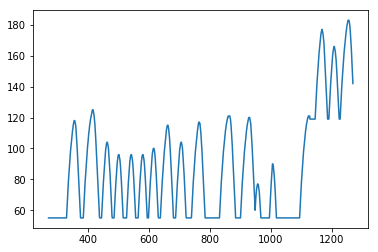

In [3]:

tracksToKeep=['track2']
kept = []
    

for track in sorted(tracks[1]):
    trackID = track[0]
    trackDict = track[1]
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
    
for track in sorted(tracks[0]):
    trackID = track
    track = tracks[0][trackID]
    trackDict = track
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
track = np.vstack(kept)
track = track[:1000,:]
plt.plot(track[:,0],256-track[:,2])
plt.show()
    

In [4]:
def thresholds(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    max_v = min(vals)
    min_v = max(vals)
    thresholds = set([0, min_v, max_v])
    for t, v in enumerate(vals):
        if (t - last_diff_t) == t_window:
            thresholds.add(last_diff)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return thresholds

axis = 2
window = 3

velocities = track[1:,axis]-track[:-1,axis] 

thresholds(velocities)

{-4, -3, -2, -1, 0, 4, 5}

In [5]:
def samey_intervals(vals, offset,t_window=5):
    last_diff = 0
    last_diff_t = 0
    intervals = []
    for t, v in enumerate(vals):
        if ((t - last_diff_t) >= t_window) and v != last_diff:
            intervals.append(last_diff_t)
            intervals.append(t)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    for i in range(len(intervals)):
        intervals[i] -= offset
    return intervals

def val_intervals(vals, value,t_window=5):
    last_diff = -1
    last_diff_t = 0
    intervals = []
    start = 0
    end = 0
    for t,v in enumerate(vals):
        if (v == value and last_diff != value) :
            start = t
        if (v != value and last_diff == value) and (t-start) >= t_window:
            intervals.append(start)
            intervals.append(t-1)
            start = t
        last_diff = v
    return intervals
axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)

print velocities

def samey_2(vals,t_window=5):
    last = vals[0]
    start = -1
    accum = 0
    intervals = []
    for t, v in enumerate(vals):
        if v != last:
            accum += 1
        if last == v:
            accum = 0
        if accum > 1:
            last = v
            if (t-accum)-start > t_window:
                intervals.append(start+1)
                intervals.append(t-accum)
                print 'adding ', intervals[-2],intervals[-1]
            start = t-accum
            accum = 0
    return intervals
            
def zero_crossings(vals,offset):
    sign_intervals = []
    last_sign_change = 0
    vsigns = np.sign(vals)
    last_sign = vsigns[0]
    for t, v in enumerate(vsigns):
        if last_sign == 0:
            last_sign = v
        elif v == 0 or v == last_sign:
            continue
        elif v != last_sign:
            sign_intervals.append(last_sign_change)
            sign_intervals.append(t)
            last_sign = v
            last_sign_change = t
    if t - 1 != last_sign_change:
        sign_intervals.append(last_sign_change)
        sign_intervals.append(t)
    for i in range(len(sign_intervals)):
        sign_intervals[i] -= offset
    return sign_intervals

axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -2 -2
 -2 -2 -2 -2 -1 -2 -1 -1 -1  0  0  1  1  1  2  3  3  3  4  4  4  4  4  5  4
  4  4  4  4  4  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3
 -3 -2 -3 -2 -2 -3 -2 -1 -2 -2 -1 -2 -1 -1 -1 -1 -1 -1 -1  0  0  1  1  1  2
  2  2  3  3  4  4  4  4  4  4  5  4  4  4  4  4  5  1  0  0  0  0  0  0 -4
 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -1 -2  0 -1  0  1  1  1  2  3  2  4
  3  4  4  5  4  4  4  5  2  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3
 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0
  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1
  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4
 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0
  0  0  0 -4

adding  0 58
adding  72 80
adding  93 104
adding  105 113
adding  128 136
adding  154 165
adding  198 206
adding  245 255
adding  399 409
adding  441 449
adding  452 468
adding  482 490
adding  505 513
adding  514 560
adding  574 582
adding  604 612
adding  613 629
adding  643 651
adding  667 677
adding  697 724
adding  748 823
adding  837 845
adding  853 874
adding  906 915
adding  944 952
adding  970 978
[0, 58, 72, 80, 93, 104, 105, 113, 128, 136, 154, 165, 198, 206, 245, 255, 399, 409, 441, 449, 452, 468, 482, 490, 505, 513, 514, 560, 574, 582, 604, 612, 613, 629, 643, 651, 667, 677, 697, 724, 748, 823, 837, 845, 853, 874, 906, 915, 944, 952, 970, 978]


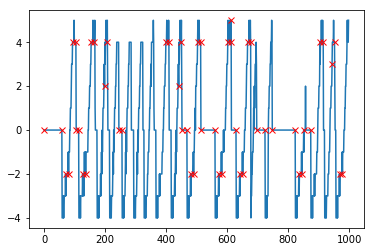

[0, 58, 105, 113, 168, 173, 209, 214, 245, 255, 286, 293, 324, 327, 361, 366, 410, 416, 452, 468, 514, 560, 590, 594, 614, 629, 697, 724, 748, 823, 853, 856, 858, 874, 916, 919]


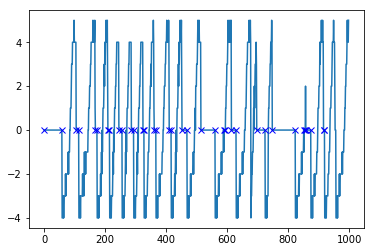

0
[0, 58, 105, 113, 245, 255, 286, 293, 452, 468, 514, 560, 614, 629, 697, 724, 748, 823, 858, 874]


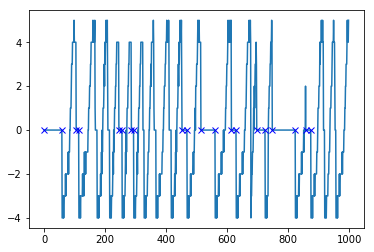

4
5
-1
-4
-3
-2


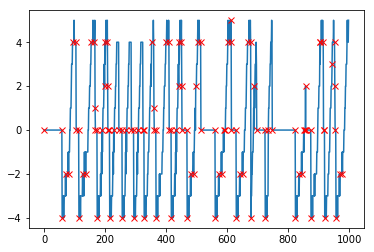

108


In [6]:
axis = 2

velocities = track[1:,axis]-track[:-1,axis] 

same_window = 8

smoothed_points = set()
for w in range(1,2):
    smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(w)/w)
    
    
    
    #print smoothed
    points = samey_2(smoothed,t_window=same_window)
    if points[-1] >= len(smoothed):
        points = points[:-1]
    smoothed_points |= set(points)
    
    print points
    
    plt.plot(smoothed)
    plt.plot(np.array(list(points)),velocities[np.array(list(points),dtype='int')],'rx')
    #plt.plot(np.array(list(smoothed_points)),smoothed[np.array(list(smoothed_points),dtype='int')],'ro')
    plt.show()
    points = val_intervals(smoothed,0,t_window=4)
    if len(points) > 0:
        if points[-1] >= len(smoothed):
            points = points[:-1]
        smoothed_points |= set(points)

        print points

        plt.plot(velocities)
        plt.plot(np.array(list(points)),velocities[np.array(list(points),dtype='int')],'bx')
        #plt.plot(np.array(list(smoothed_points)),smoothed[np.array(list(smoothed_points),dtype='int')],'ro')
        plt.show()
    for val in thresholds(velocities) :
        print val
        points = val_intervals(smoothed,val,t_window=8)
        if len(points) > 0:
            if points[-1] >= len(smoothed):
                points = points[:-1]
            smoothed_points |= set(points)

            print points

            plt.plot(velocities)
            plt.plot(np.array(list(points)),velocities[np.array(list(points),dtype='int')],'bx')
            #plt.plot(np.array(list(smoothed_points)),smoothed[np.array(list(smoothed_points),dtype='int')],'ro')
            plt.show()
smoothed_points |= set(list(1+np.where(np.abs(velocities[1:]-velocities[:-1]) > 1)[0]))



velocity_times = list(sorted(smoothed_points))
if velocity_times[-1] >= len(track[:,axis]):
    velocity_times = velocity_times[:-1]

plt.plot(velocities)
plt.plot(np.array(velocity_times),velocities[np.array(velocity_times,dtype='int')],'rx')
plt.show()
print len(velocity_times)

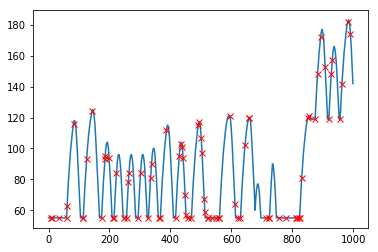

In [7]:
import fceulib
inputVec = fceulib.readInputs('Illustrative.fm2')

def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    for t, b in enumerate(button_masks):
        if t < track[0,0]:
            continue
        if t > track[-1,0]:
            break
        if b != last_mask:
            mask_times.append(t-track[0,0])
            last_mask = b
    return mask_times

button_times = button_change_times(inputVec)

plt.plot(256-track[:,2])
plt.plot(np.array(button_times),256-track[np.array(button_times),axis],'rx')
plt.show()


In [8]:
# Templates is an array of model-generating functions of increasing complexity.
templates = [
    # Constant 0 velocity
    ("c0",lambda n,axis,vs,pv: pm.Normal(
        n, 
        mu=0,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant velocity from old value
    ("cP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Fixed constant velocity
    ("cN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10),
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from 0
    ("acc0",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from old velocity value
    ("accP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv+pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from fixed constant velocity
    ("accN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10)+pm.Normal(n+"_acc",mu=0,sd=20)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
]
templates = templates
type2ind = {t[0]:i for i,t in enumerate(templates)}
print type2ind

{'accN': 5, 'cN': 2, 'acc0': 3, 'c0': 0, 'cP': 1, 'accP': 4}


In [9]:
iterations = 5000
from pymc3 import find_MAP
def model_template_generate(template_i, axis, segment, prev_val):
    axisNames = [None,"x","y"]
    template = templates[template_i]
    (tn, t) = template
    with pm.Model() as model:
        lik = t(axisNames[axis],axis,segment,prev_val)
        step = pm.Metropolis()
        trace = pm.sample(iterations, step, progressbar=True, njobs=1, n_init=2000)
        subtrace = trace[len(trace)/2:-1:10]
    return (tn,model,subtrace)

In [10]:
def model_set_generate(data):
    track,all_times,axis,i,j = data
    t0 = all_times[i]
    t1 = all_times[j]
    print "go",i,j,t0,t1
    if t0 == 0:
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = float('inf')
    elif t1+1 > np.shape(track)[1]:
        extended_track = np.concatenate((track,[track[-1]]))
        segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    else:
        #9,10,11 - 8,9,10
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    segment[:,0] = range(0,np.shape(segment)[0])
    result = map(
        lambda ti: model_template_generate(ti, 
                                           axis,-
                                           segment,
                                           prev_vel),
        range(0,len(templates)))
    return (i,j,t0,t1,result)

In [ ]:
%%time
iterations = 2000
all_times = sorted(set(velocity_times + button_times))
print len(all_times)
all_times = [t for t in all_times if (t>=0 and t < len(velocities))]

likes = [None]*len(all_times)

plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for i in range(0,len(all_times)):
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    print t0
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]:
        js = model_set_generate((track,all_times,axis,i,j))
        the_templates = js[-1]
        foundOne = False
        for tn,mod,trace in the_templates:
            logp = -np.mean([mod.logp(pt) for pt in trace])/float(all_times[j]-all_times[i])
            print logp
            if logp < min_likelihood:
                min_likelihood = logp
                foundOne = True
        if not foundOne:
            break
        likes[i][j] = js
        
    #js = map(model_set_generate,
    #         map(lambda j:(track,all_times,axis,i,j), [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]))
    #likes[i][i+1:len(all_times)] = js

print "Done!"

In [ ]:
for li in likes[0:10]:
    for lij in li[0:10]:
        if lij is None or lij == []: 
            continue
        (i,j,t0,t1,models) = lij
        print i,j,t0,t1
        for m in models:
            print m[0],pm.df_summary(m[-1])
        print "\n"

In [ ]:
# What is the mode as of just before each switch-point, 
# and what is the accumulated cost of the approximation up to that point?
modes = [(0,None)]*(len(all_times))

#modes is offset from likes by 1

ks = {"c0":1, "cP":1, "cN":2, "acc0":2, "accP":2, "accN":3}

cost = 1

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    print "j",j
    for i in range(0, j):
        data = likes[i][j]
        if not data:
            continue
        dt = data[3]-data[2]
        if dt < min_interval:
            print data[:4]
            continue
        the_templates = data[-1]
        print "i",i
        for tn,mod,trace in the_templates:
            k = ks[tn]
            summary = pm.df_summary(trace)
            logp = np.mean([mod.logp(pt) for pt in trace])
            # WAIC
            #crit = -pm.stats.waic(model=mod,trace=trace)
            # DIC
            #crit = pm.stats.dic(model=mod,trace=trace)
            #if np.abs(crit) > 1e5:
            #    crit = float('inf')
            # BPIC
            #crit = pm.stats.bpic(model=mod,trace=trace)
            # AICc
            #crit = 2*k - 2 * logp + (2*(k+1)*(k+2))/(dt-k-2)
            # BIC
            crit = math.log(dt)*k - 2 * logp
            # max-likelihood
            #crit = -logp
            
            #crit = math.log(dt) - logp
            m_prev = modes[i][0]
            # ??
            #crit = summary["mean"]["y_err"]*dt+dt*k
            here = crit + m_prev + math.log(dt)
            print i,j,data[2],data[3],tn,logp,summary["mean"]["y_err"],crit,here,least
            if here < least:
                print "update least",here
                least = here
                # prev_i,this_j,t0,t1,name,summary,criterion
                least_template = (i,j,data[2],data[3],tn,summary,crit)
    modes[j] = (least, least_template)


In [14]:
def get_path(modes):
    mj = len(modes)-1
    path = [modes[mj]]
    while mj > 0:
        mj = modes[mj][1][0]
        path.append(modes[mj])
    return list(reversed(path))[1:]

path = get_path(modes)
for ii,p in enumerate(path):
    print ii,p[0],'\n',p[1],'\n'

0 -41043.2102888 
(0, 5, 0, 59, 'c0',                 mean             sd       mc_error        hpd_2.5  \
y_err  7.595110e-155  1.388898e-156  1.388898e-157  7.461157e-155   

            hpd_97.5  
y_err  7.888875e-155  , -41047.287826264903) 

1 -40991.8973447 
(5, 8, 59, 80, 'accN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N    4.040934  0.174880  0.017488  3.683374  4.344497
y_acc  0.128570  0.015221  0.001522  0.096102  0.157366
y_err  0.377178  0.065574  0.006557  0.267464  0.487339, 48.268421660610748) 

2 -40948.6982525 
(8, 10, 80, 93, 'accN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N    1.889571  0.226647  0.022665  1.462683  2.356163
y_acc  0.432406  0.032030  0.003203  0.372368  0.498928
y_err  0.394647  0.093110  0.009311  0.210871  0.559662, 40.634142838761846) 

3 -40921.2921601 
(10, 12, 93, 105, 'cN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -4.092072  0.089863  0.008986 -4.314529 -3.948672
y_err  0.328957  0.091

In [15]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


In [ ]:
cross = {}
unions = UnionFind()

for ii,mode in enumerate(path):
    d = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}
    model,trace = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}[mode[1][4]]
    for jj,mode2 in enumerate(path):
        model2,trace2 = {t[0]:t[1:] for t in likes[mode2[1][0]][mode2[1][1]][4]}[mode2[1][4]]
        if mode2[1][4] == mode[1][4]:
            print 'here'
            try:
                
                crit = -np.mean([model.logp(pt) for pt in trace2])#pm.stats.dic(model=model,trace=trace2)
            except:
                print 'except?'
                crit = float('inf')
        else:
            crit = float('inf')
        
        cross[(ii,jj)] = crit

In [ ]:
complexityWeight = 30
for d in sorted(cross):
    good = True
    print d,[cross[d], cross[(d[0],d[0])], cross[(d[1],d[1])], cross[(d[1],d[0])]]
    for t in [cross[d], cross[(d[0],d[0])], cross[(d[1],d[1])], cross[(d[1],d[0])]]:
        if t == float('inf'):
            good = False
    if not good:
        continue
    joined = min(cross[d] + cross[(d[0],d[0])],cross[(d[1],d[1])]+cross[(d[1],d[0])])
    print d, joined , (cross[(d[0],d[0])]+cross[(d[1],d[1])])
    if (joined < (cross[(d[0],d[0])]+cross[(d[1],d[1])]) +complexityWeight):
        unions.union(d[0],d[1])
merged = {}
for u in unions:
    print u, unions[u]
    if unions[u] not in merged:
        merged[unions[u]] = set()
    merged[unions[u]].add(u)
print merged

In [18]:
iterations = 1000

def model_sets_generate(ti,data):
    track,all_times,axis,i,j = data
    segments = []
    for ind in range(len(i)):
        t0 = all_times[i[ind]]
        t1 = all_times[j[ind]]
        if t0 == 0:
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = 0
        elif t1+1 > np.shape(track)[1]:
            extended_track = np.concatenate((track,[track[-1]]))
            segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        else:
            #9,10,11 - 8,9,10
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        segment[:,0] = range(0,np.shape(segment)[0])
        segments.append(segment)
    segment = np.vstack(segments)
    result = model_template_generate(ti, 
                                       axis,
                                       segment,
                                       prev_vel)
    return (i,j,t0,t1,result)

for m in merged:
    print ''
    if len(merged[m]) > 1:
        i_ = []
        j_ = []
        for t in merged[m]:
            mode = path[t]
            dat = likes[mode[1][0]][mode[1][1]]            
            ti = type2ind[mode[1][4]]
            i_.append(dat[0])
            j_.append(dat[1])
            
        result = model_sets_generate(ti,(track,all_times,axis,i_,j_))
        print pm.df_summary(result[4][2])

100%|██████████| 1000/1000 [00:00<00:00, 7036.61it/s]


               mean            sd      mc_error        hpd_2.5      hpd_97.5
y_err  5.213995e-97  3.492227e-96  4.938755e-97  7.461334e-155  8.175923e-99



100%|██████████| 1000/1000 [00:00<00:00, 4215.21it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -4.490370  0.097363  0.013769 -4.663676 -4.320230
y_acc  0.218800  0.005831  0.000825  0.210735  0.227972
y_err  1.262715  0.044600  0.006307  1.205131  1.368058



100%|██████████| 1000/1000 [00:00<00:00, 6504.57it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N    4.062744  0.044916  0.006352  3.984417  4.143467
y_err  0.508918  0.043917  0.006211  0.441747  0.600455



100%|██████████| 1000/1000 [00:00<00:00, 6587.43it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -3.289608  0.126494  0.017889 -3.524523 -3.076192
y_err  0.800915  0.096171  0.013601  0.621092  0.999248



100%|██████████| 1000/1000 [00:00<00:00, 6329.68it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_acc  0.351800  0.013146  0.001859  0.332295  0.378790
y_err  0.757805  0.071139  0.010061  0.646049  0.906585



100%|██████████| 1000/1000 [00:00<00:00, 11923.77it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_err  1.455238  0.120758  0.017078  1.223629  1.701372





100%|██████████| 1000/1000 [00:00<00:00, 4546.78it/s]

           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -1.457296  0.100819  0.014258 -1.626496 -1.286054
y_acc  0.415131  0.016740  0.002367  0.375600  0.442007
y_err  0.500666  0.046571  0.006586  0.417961  0.581950


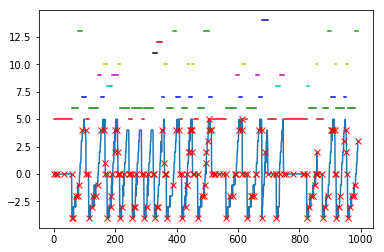

In [19]:
colors = ['r','g','b','c','m','y','k',"#aa0000","#00aa00","#0000aa","#880000","#008800","#000088"]
merged2color = {m:i for i,m in enumerate(sorted(merged))}

for m in merged:
    for t in merged[m]:
        plt.plot(np.array(path[t][1][2:4]),np.array([merged2color[m], merged2color[m]])+5,colors[merged2color[m]])

plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

In [20]:
collisions = pickle.load(open('mario_collisions.pkl'))

def button_changes(button_masks):
    last_mask = 0
    mask_times = {}
    for t, b in enumerate(button_masks):
        if b != last_mask:
            b_ = int(b)
            buttons = []
            for ii,c in enumerate(list('RLDUTSBA')):
                if b_ & (1 << (7-ii)):
                    buttons.append(c)
            l_ = int(last_mask)
            last_buttons = []
            for ii,c in enumerate(list('RLDUTSBA')):
                if l_ & (1 << (7-ii)):
                    last_buttons.append(c)
            mask_times[t] = (last_buttons,buttons)
            last_mask = b
    
    return mask_times

button_times = button_changes(track[:,3])
for t in sorted(button_times):
    print t, button_times[t]

0 ([], ['D', 'T'])
15 (['D', 'T'], ['D', 'T', 'A'])
18 (['D', 'T', 'A'], ['D', 'T', 'B'])
19 (['D', 'T', 'B'], ['D', 'T', 'B', 'A'])
21 (['D', 'T', 'B', 'A'], ['D', 'T', 'S'])
23 (['D', 'T', 'S'], ['D', 'T', 'S', 'A'])
24 (['D', 'T', 'S', 'A'], ['D', 'T', 'S', 'B'])
25 (['D', 'T', 'S', 'B'], ['D', 'T', 'S', 'B', 'A'])
26 (['D', 'T', 'S', 'B', 'A'], ['D', 'U'])
27 (['D', 'U'], ['D', 'U', 'A'])
28 (['D', 'U', 'A'], ['D', 'U', 'B'])
29 (['D', 'U', 'B'], ['D', 'U', 'B', 'A'])
30 (['D', 'U', 'B', 'A'], ['D', 'U', 'S'])
31 (['D', 'U', 'S'], ['D', 'U', 'S', 'A'])
32 (['D', 'U', 'S', 'A'], ['D', 'U', 'S', 'B', 'A'])
33 (['D', 'U', 'S', 'B', 'A'], ['D', 'U', 'T'])
34 (['D', 'U', 'T'], ['D', 'U', 'T', 'A'])
35 (['D', 'U', 'T', 'A'], ['D', 'U', 'T', 'B', 'A'])
36 (['D', 'U', 'T', 'B', 'A'], ['D', 'U', 'T', 'S'])
37 (['D', 'U', 'T', 'S'], ['D', 'U', 'T', 'S', 'A'])
38 (['D', 'U', 'T', 'S', 'A'], ['D', 'U', 'T', 'S', 'B'])
39 (['D', 'U', 'T', 'S', 'B'], ['D', 'U', 'T', 'S', 'B', 'A'])
40 (['D', 'U'

In [21]:
start_time = 270
from_x_to_y = {}
to_y = {}
for t in range(1,len(path)):
        if t == 0:
            prev = -1
        else:
            prev = unions[t-1]
            
        start = path[t][1][2]
        
        print t,prev,'->',unions[t], start
        if start in button_times:
            print 'button', button_times[start]
        
        if start+start_time in collisions:
            for c in collisions[start+start_time]:
                print '\t',c
        print ''

1 4 -> 5 59
	((51, 0, 'tile'), 'left')
	((36, 0, 'tile'), 'right')
	((180, 1, 'tile'), 'top')
	((51, 0, 'tile'), 'internal')
	((36, 0, 'tile'), 'left')
	((36, 0, 'tile'), 'bottom')
	((36, 0, 'tile'), 'internal')
	((181, 1, 'tile'), 'top')

2 5 -> 6 82
	((36, 0, 'tile'), 'internal')
	((36, 0, 'tile'), 'right')
	((36, 0, 'tile'), 'bottom')
	((36, 0, 'tile'), 'top')
	((36, 0, 'tile'), 'left')

3 6 -> 7 93
	((36, 0, 'tile'), 'internal')
	((36, 0, 'tile'), 'right')
	((36, 0, 'tile'), 'bottom')
	((36, 0, 'tile'), 'top')
	((36, 0, 'tile'), 'left')

4 7 -> 4 105
button (['D', 'U', 'S', 'B', 'A'], ['D', 'U', 'S', 'A'])
	((180, 1, 'tile'), 'top')
	((52, 0, 'tile'), 'bottom')
	((51, 0, 'tile'), 'bottom')
	((52, 0, 'tile'), 'internal')
	((38, 0, 'tile'), 'right')
	((51, 0, 'tile'), 'internal')
	((38, 0, 'tile'), 'left')
	((181, 1, 'tile'), 'top')
	((38, 0, 'tile'), 'internal')
	((51, 0, 'tile'), 'right')
	((52, 0, 'tile'), 'left')
	((38, 0, 'tile'), 'bottom')

5 4 -> 5 114
button (['D', 'T', 'A'],